### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt

In [2]:
FEATURES = [
    'service_quality','cleanliness','condition_state','comfort','location_convenience',
    'accessibility','crowdedness','safety','atmosphere','value_for_money',
    'infrastructure_availability','noise_level','navigation_ease','waiting_time','recommend_intent'
]
seed = 77

### Split (leave-1-out per user)

In [3]:
def make_split_leave1out(df: pd.DataFrame, user_col="user_id", seed=42):
    rng = np.random.default_rng(seed)
    df = df.copy()
    df["__is_test__"] = False

    for _, g in df.groupby(user_col):
        if len(g) <= 1:
            continue
        test_idx = rng.choice(g.index.to_numpy(), size=1)[0]
        df.loc[test_idx, "__is_test__"] = True

    mask = df["__is_test__"].astype(bool).to_numpy()
    train = df.loc[~mask].drop(columns="__is_test__")
    test  = df.loc[ mask].drop(columns="__is_test__")
    return train, test

### Build user profile from TRAIN only

In [4]:
def build_user_profile(train: pd.DataFrame, user_col="user_id"):
    agg = {
        "u_mean_rating": ("rating", "mean"),
        "u_std_rating":  ("rating", "std"),
        "u_cnt":         ("rating", "size"),
    }
    for f in FEATURES:
        agg[f"u_mean_{f}"] = (f, "mean")

    prof = train.groupby(user_col).agg(**agg).reset_index()
    prof["u_std_rating"] = prof["u_std_rating"].fillna(0.0)
    return prof

### Feature engineering

In [22]:
def add_features(df: pd.DataFrame, user_prof: pd.DataFrame, user_col="user_id"):
    out = df.merge(user_prof, on=user_col, how="left")

    # если пользователь вообще не встречался в train (редко, но бывает) — заполним дефолтами
    out["u_cnt"] = out["u_cnt"].fillna(0)
    out["u_mean_rating"] = out["u_mean_rating"].fillna(out["rating"].mean())
    out["u_std_rating"]  = out["u_std_rating"].fillna(0.0)

    for f in FEATURES:
        out[f"u_mean_{f}"] = out[f"u_mean_{f}"].fillna(out[f].mean())
        out[f"diff_{f}"] = (out[f].astype(float) - out[f"u_mean_{f}"].astype(float)).abs()

    return out

In [6]:
def get_feature_cols():
    return FEATURES + [f"diff_{f}" for f in FEATURES] + ["u_cnt", "u_mean_rating", "u_std_rating"]


In [18]:
df = pd.read_csv('final_dataset.csv')

In [19]:
df.head()

,_row_id,address,name_ru,rating,rubrics,text,len_text,count_note,accessibility,atmosphere,...,location_convenience,navigation_ease,noise_level,recommend_intent,safety,service_quality,value_for_money,waiting_time,_error,user_id
0,2000,"Курская область, Золотухинский район, местечко...",Коренная пустынь,5.0,Монастырь,"Хорошее место, намоленное. Чувствуется спокойс...",99,5,0.0,0.9,...,0.0,0.0,0.0,0.7,0.0,0.0,0.0,0.0,NaN,1934
1,4000,"Москва, Верхняя Радищевская улица, 15, стр. 1",Алёша и Графин,5.0,"Бар, паб",Отличное заведение с демократичными ценами. Че...,166,5,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,1917
2,6000,"Московская область, городской округ Истра, Дед...",Оптика 2.0,5.0,Салон оптики,Самая лучшая оптика в городе. Уже много лет бе...,297,5,0.6,0.9,...,0.7,0.6,0.3,1.0,0.8,1.0,1.0,0.5,NaN,587
3,0,"Санкт-Петербург, Московский проспект, 183-185Ак4",Лик,5.0,Косметология;Салон красоты;Ногтевая студия;Эпи...,Посещаю клинику уже 4 месяца. Радует всё! Обсл...,312,5,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,591
4,4001,"Москва, Верхняя Радищевская улица, 15, стр. 1",Алёша и Графин,5.0,"Бар, паб",Хорошее заведение. Демократические цены . реко...,63,5,0.5,0.7,...,0.5,0.5,0.5,0.9,0.5,0.7,0.8,0.5,NaN,891


In [20]:
required = ["user_id", "rating"] + FEATURES
missing = [c for c in required if c not in df.columns]
if missing:
    raise KeyError(f"Missing columns: {missing}")

In [23]:
train_raw, test_raw = make_split_leave1out(df, seed=seed)
user_prof = build_user_profile(train_raw)
train = add_features(train_raw, user_prof)
test  = add_features(test_raw, user_prof)

In [24]:
feat_cols = get_feature_cols()
X_train, y_train = train[feat_cols], train["rating"].astype(float)
X_test, y_test   = test[feat_cols],  test["rating"].astype(float)

In [46]:
model = CatBoostRegressor(
        iterations=1200,
        depth=6,
        learning_rate=0.05,
        loss_function="RMSE",
        random_seed=seed,
        verbose=False
    )

In [47]:
model.fit(X_train, y_train)

In [48]:
pred = model.predict(X_test)

In [49]:
rmse = mean_squared_error(y_test, pred) ** 0.5
mae  = mean_absolute_error(y_test, pred)
r2   = r2_score(y_test, pred)

In [50]:
metrics = {"rmse": rmse, "mae": mae, "r2": r2}

In [51]:
print(metrics)

{'rmse': 0.764783674537344, 'mae': 0.3182419382995056, 'r2': 0.12777254270885352}


In [30]:
res = test_raw.copy()
res["pred_rating"] = pred
res["error"] = res["pred_rating"] - res["rating"].astype(float)
res["abs_error"] = res["error"].abs()

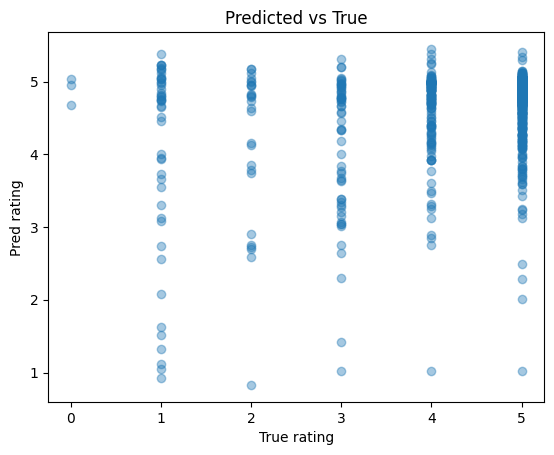

In [32]:
plt.figure()
plt.scatter(res["rating"], res["pred_rating"], alpha=0.4)
plt.xlabel("True rating")
plt.ylabel("Pred rating")
plt.title("Predicted vs True")
plt.show()

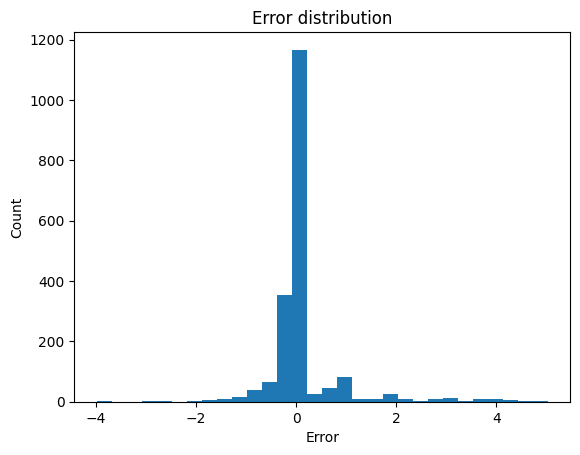

In [52]:
plt.figure()
plt.hist(res["error"], bins=30)
plt.xlabel("Error")
plt.ylabel("Count")
plt.title("Error distribution")
plt.show()

/var/folders/96/5q60w2vs6sb74wvvssyfl7f00000gn/T/ipykernel_7766/2108913029.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = tmp.groupby("cnt_bin")["abs_error"].mean().reset_index()


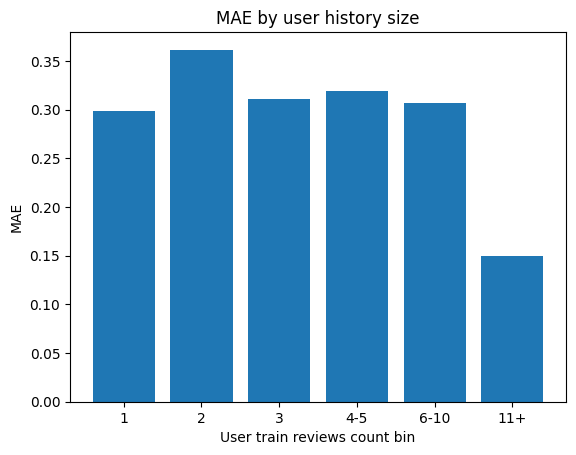

In [35]:
cnt = train_raw.groupby("user_id").size().rename("train_cnt")
tmp = res.merge(cnt, on="user_id", how="left").fillna({"train_cnt": 0})

# бины по количеству
bins = [-1, 0, 1, 2, 3, 5, 10, 1000000]
labels = ["0", "1", "2", "3", "4-5", "6-10", "11+"]
tmp["cnt_bin"] = pd.cut(tmp["train_cnt"], bins=bins, labels=labels)

grp = tmp.groupby("cnt_bin")["abs_error"].mean().reset_index()

plt.figure()
plt.bar(grp["cnt_bin"].astype(str), grp["abs_error"])
plt.xlabel("User train reviews count bin")
plt.ylabel("MAE")
plt.title("MAE by user history size")
plt.show()

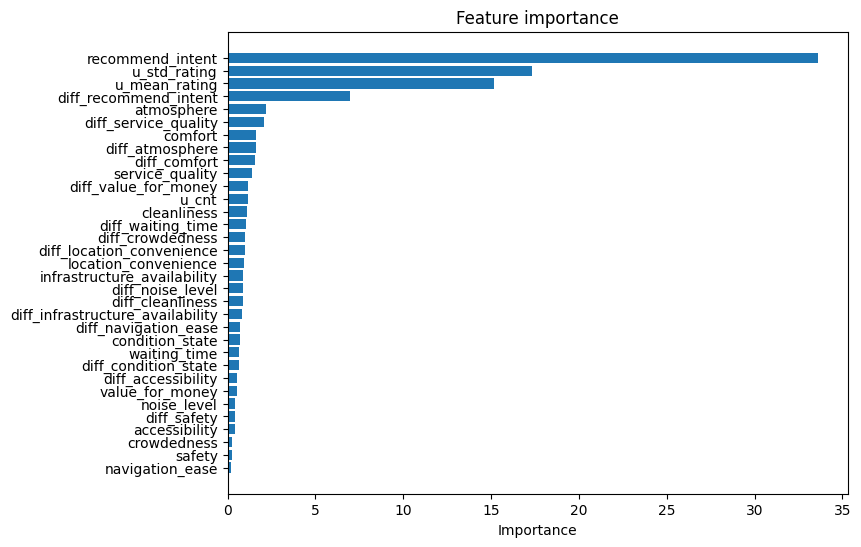

In [39]:
imp = model.get_feature_importance()
fi = pd.DataFrame({"feature": feat_cols, "importance": imp}).sort_values("importance", ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(fi["feature"], fi["importance"])
plt.xlabel("Importance")
plt.title("Feature importance")
plt.show()